In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

from import_funcs import get_data_structured

In [50]:
#fpath = Path('/data/users/tch14/slurm_runs/100942')
#obs = get_data_structured(fpath,
#                         requested_observables = ['Fc', 'Ff', 'IPRs', 'Mf_moments', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'proposal_rates', 'state', 'time'],
#                         structure_names = ('repeats','Us','Ts'),
#                         )

#import pickle 
#with open(fpath/'data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(obs, f, pickle.HIGHEST_PROTOCOL)

In [6]:
import pickle

fpath = Path('/data/users/tch14/slurm_runs/99788')
with open(fpath/'data.pickle', 'rb') as f:
     coarse = pickle.load(f)
             
fpath = Path('/data/users/tch14/slurm_runs/100942')
with open(fpath/'data.pickle', 'rb') as f:
     fine = pickle.load(f)

In [32]:
obs.time.shape, obs.time_shapehint

((6, 10, 10, 10), ('Ns', 'repeats', 'Us', 'Ts'))

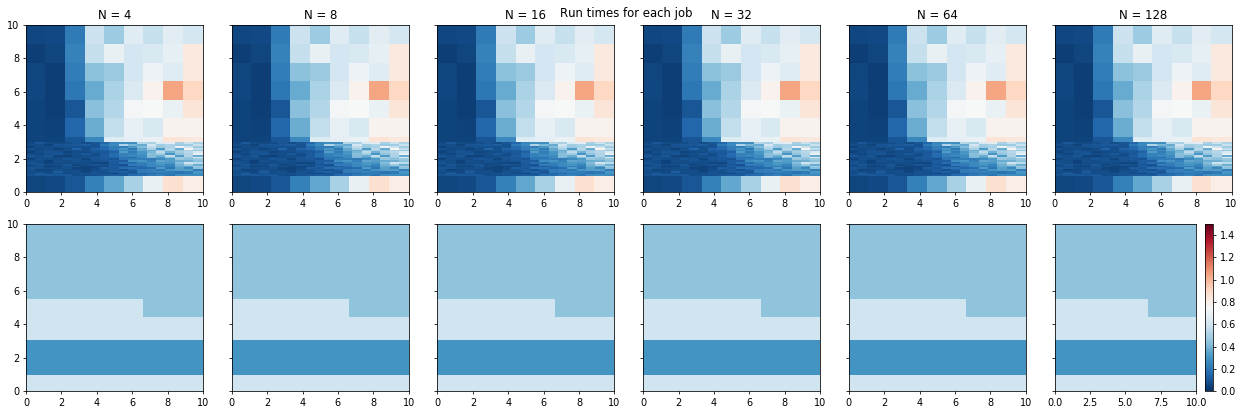

In [7]:
from matplotlib import colors
from itertools import count


f, axes = plt.subplots(2,6, figsize = (6*3,6), sharey = 'row')

for obs in [coarse, fine]:
    t = np.nanmean(obs.time, axis = 1)
    n = np.sum(np.isfinite(obs.time), axis = 1)

    for i, N, (ax1, ax2) in zip(count(), obs.Ns, axes.T):
        ax1.set(title = f'N = {N}')
        norm1 = colors.Normalize(vmin = 0, vmax = 1.5)
        cs1 = ax1.pcolormesh(obs.Us, obs.Ts, t[i]/60**2, cmap='RdBu_r', norm = norm1)

        norm2 = colors.Normalize(vmin = 0, vmax = 10)
        cs2 = ax2.pcolormesh(obs.Us, obs.Ts, n[i], cmap='RdBu_r', norm = norm2)
    
#ax1.colorbar(cs1) 
#ax2.colorbar(cs2) 

f.colorbar(cs1)
f.suptitle("Run times for each job")
f.tight_layout()

## Order Parameter

In [39]:
coarse.Mf_moments.shape, coarse.Mf_moments_shapehint

((6, 10, 10, 10, 5, 100), ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep'))

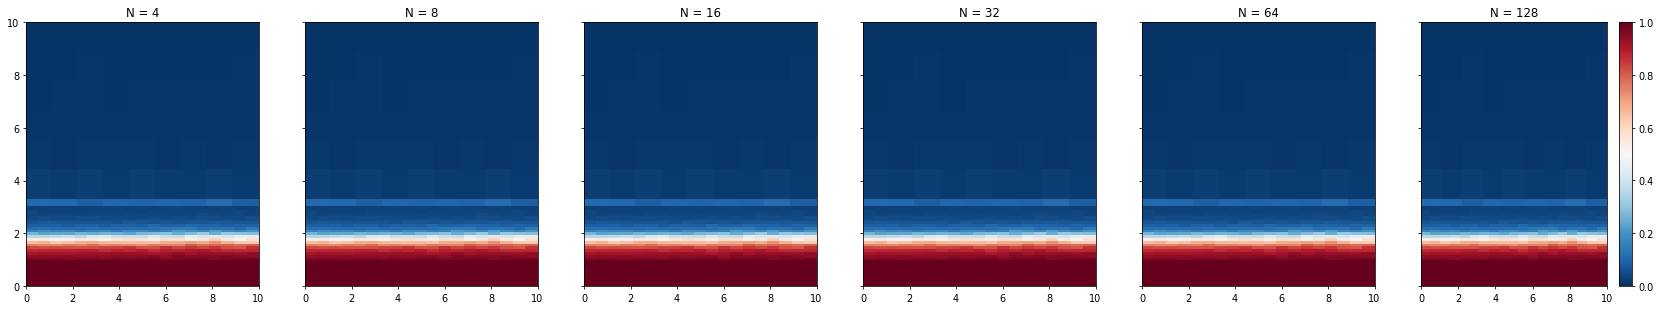

In [8]:
from matplotlib import colors
from itertools import count
norm = colors.Normalize(vmin=0, vmax=1)

f, axes = plt.subplots(1,6, figsize = (6*5,5), sharey = 'row')

for obs in [coarse, fine]:    
    Y = np.nanmean(obs.Mf_moments[:, :, :, :, 2, :], axis = (1,-1))

    for i, N, ax in zip(count(), obs.Ns, axes):
        ax.set(title = f'N = {N}')
        cs = ax.pcolormesh(obs.Us, obs.Ts, Y[i].T, cmap='RdBu_r', norm = norm)

f.colorbar(cs)
f.savefig('TU_phase_diagram.pdf')

#save for plotting elsewhere
i = -1
data = dict(
    command = 'cs = ax.pcolormesh(U, T, Y, cmap="RdBu_r", norm = norm)',
    N = obs.Ns[i],
    Yfine = np.nanmean(fine.Mf_moments[:, :, :, :, 2, :], axis = (1,-1))[i].T,
    U = obs.Us,
    T = obs.Ts,
)
f = '/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs/phase_diagram_UT.npz'
np.savez(f, **data)
    

In [45]:
obs.Mf_moments.shape, obs.Mf_moments_shapehint

((6, 2, 20, 20, 5, 200), ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep'))

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


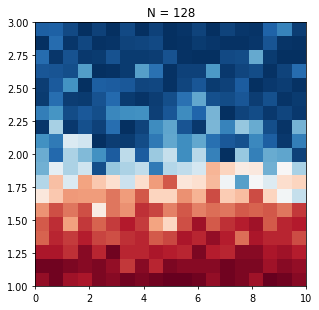

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

norm = colors.Normalize(vmin=0, vmax=1)
f, ax = plt.subplots(1,1, figsize = (5,5), sharey = 'row')

obs = fine
i = -1
Y = np.nanmean(obs.Mf_moments[i, :, :, :, 2, :], axis = (0))
cs = None


#f.colorbar(cs)

def init():
    ax.set(title = f'N = {128}')
    global cs
    cs = ax.pcolormesh(obs.Us, obs.Ts, np.nanmean(Y[..., :1], axis = -1).T, cmap='RdBu_r', norm = norm)
    return cs, 

def update(frame):
    thisY = np.nanmean(Y[..., :frame], axis = -1).T
    cs.set_array(thisY[:-1, :-1].ravel())
    return cs,

ani = FuncAnimation(f, update, frames=np.linspace(0, np.sqrt(200), 50, dtype = np.int),
                    init_func=init, blit=False)
ani.save('animation.mp4')
#HTML(ani.to_html5_video())

## Binder cumulant

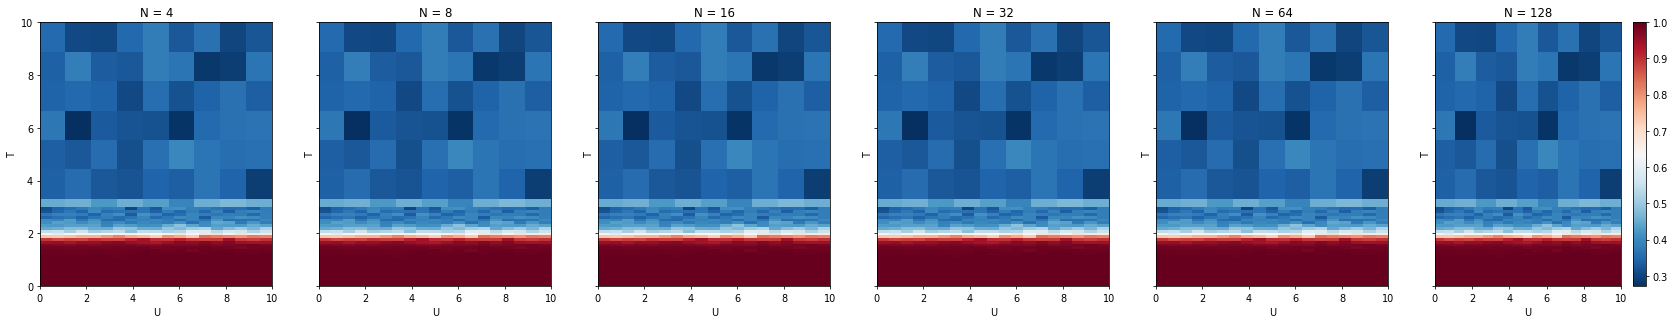

In [46]:
norm = colors.Normalize()

f, axes = plt.subplots(1,6, figsize = (6*5,5), sharey = 'row')

for obs in [coarse, fine]:
    
    M = np.nanmean(obs.Mf_moments, axis = (1,-1)) # now has shape ('Ns', 'Us', 'Ts', 'moment')
    Y = M[..., 2]**2 / M[..., 4]

    for i, N, ax in zip(count(), obs.Ns, axes):
        ax.set(title = f'N = {N}', xlabel = 'U', ylabel = 'T')
        cs = ax.pcolormesh(obs.Us, obs.Ts, Y[i, ...].T, cmap='RdBu_r', norm = norm)
    

f.colorbar(cs)